# Running the simulations

In [8]:
r_max, hex_size = 75, 1.56
length = 2600
liquid_gap = 5
gas_gap = 5
drift_field = 100

In [9]:
Xenoscope = TPC(r_max, length, liquid_gap, gas_gap, drift_field)
mesh = Xenoscope.gate_mesh
lamp = XeLamp(1)

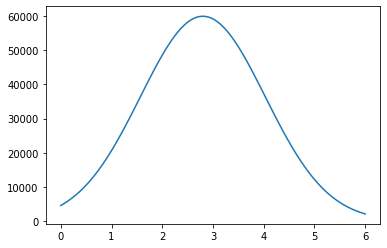

In [78]:
_t = np.linspace(0,6,100)
plt.plot(_t, lamp.pulse_lamp(_t))
plt.show()

182208


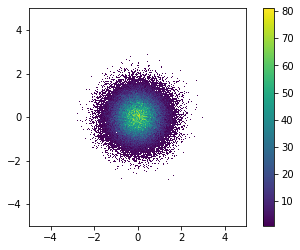

In [214]:
population = lamp.emitted_electrons_in_interval(0,6)
print(population)
x0,y0,z0 = lamp.init_positions(population)

plt.hist2d(x0,y0, bins = 200, cmin = 1)
plt.gca().set_aspect('equal')
plt.ylim(-5,5)
plt.xlim(-5,5)
plt.colorbar()
plt.show()

#### Drifting a slice of lamp pulse

In [32]:
lamp = XeLamp(delta_t_lamp = 1)
drifting = ElectronDrift(tpc = Xenoscope, 
                         xelamp = lamp,
                         drift_delta_t = 1)

In [28]:
x,y,z = drifting.drift_lamp_pulse_slice(0,6)

In [71]:
def plot_xy(fig,ax,x,y,stuff = {}):
    hh = ax.hist2d(x,y, bins = 200, cmin = 1)
    ax.set_aspect('equal')
    ax.set_title('%.2f us : %.2f us' %(stuff['lamp_start'],stuff['lamp_end']))
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    fig.colorbar(hh[3], ax = ax)
    return fig,ax

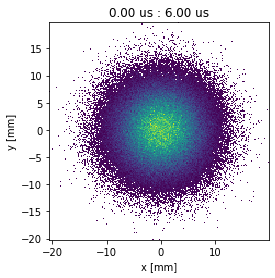

In [52]:
fig, ax = plt.subplots(1,1,figsize = (9,4))
ax = plot_xy(ax,x,y,{'lamp_start':0, 'lamp_end':6})
plt.show()

#### Drifting all the lamp pulse

In [64]:
lamp = XeLamp(delta_t_lamp = 1)
drifting = ElectronDrift(tpc = Xenoscope, 
                         xelamp = lamp,
                         drift_delta_t = 1)

In [65]:
pos_lamp_pulse = drifting.drift_full_pulse(lamp_end_time = 6)

100%|██████████| 7/7 [00:40<00:00,  5.84s/it]


In [66]:
pos_lamp_pulse['slice_0'].keys()

dict_keys(['start', 'end', 'delta_t_lamp', 'x', 'y', 'z'])

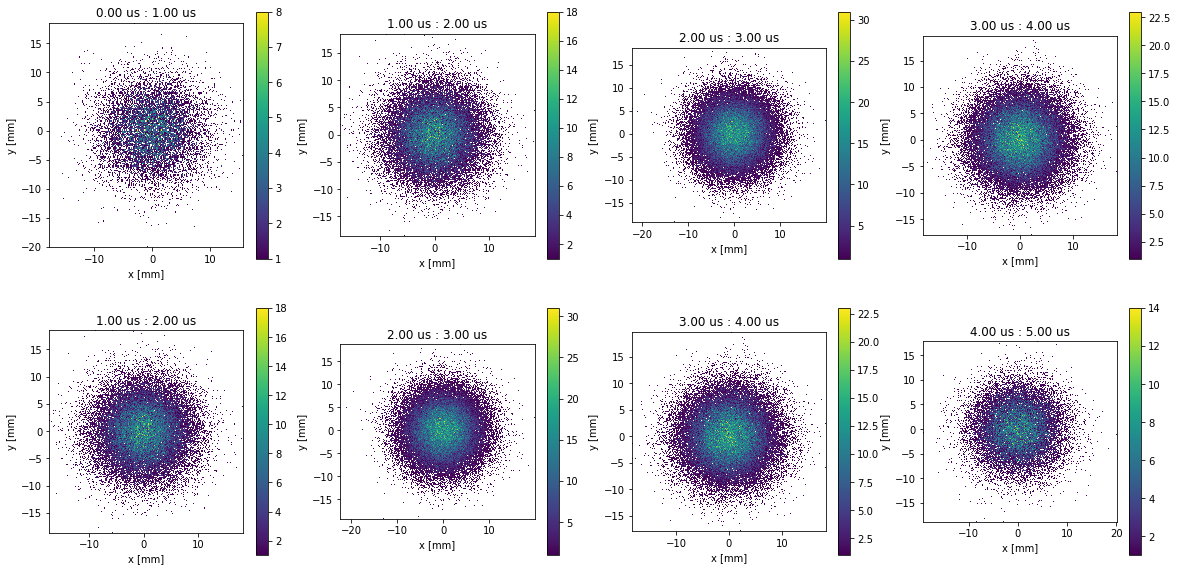

In [72]:
fig, axs = plt.subplots(2,4,figsize = (20,10))
rows,columns = axs.shape
for _row in range(rows):
    for _col in range(columns):
        ax_i = _row + _col
        if ax_i > len(pos_lamp_pulse):
            break
        lamp_start = pos_lamp_pulse['slice_%d'%ax_i]['start']
        lamp_end = pos_lamp_pulse['slice_%d'%ax_i]['end']
        x = pos_lamp_pulse['slice_%d'%ax_i]['x']
        y = pos_lamp_pulse['slice_%d'%ax_i]['y']
        axs[_row,_col] = plot_xy(fig,axs[_row,_col],x,y,{'lamp_start':lamp_start, 'lamp_end':lamp_end})

plt.show()

#### Using the fully integrated lamp pulse

In [133]:
lamp = XeLamp(delta_t_lamp = 1)
drifting = ElectronDrift(tpc = Xenoscope, 
                         xelamp = lamp,
                         drift_delta_t = 1)
drifting.e_lifetime = 2000

In [97]:
x,y,z = drifting.drift_lamp_pulse_slice(0,6)

In [134]:
x_corr_elifetime,y_corr_elifetime,z_corr_elifetime = drifting.apply_elifetime(x,y,z)
x_extracted,y_extracted, z_extracted = drifting.extract_electrons(x_corr_elifetime,y_corr_elifetime,z_corr_elifetime)